<a href="https://colab.research.google.com/github/mondo-lee/in2HEP/blob/master/notebooks/cuts_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# path names have been modified to reflect data from my own Github repo
from pathlib import Path

data_path = Path('../data-v2/VHbb_data_2jet.csv')
class_path = Path('ucl_masterclass.py')
if not data_path.exists():
    !wget -P ../data-v2/ https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet.csv
else:
    print("Data file already found")

if not class_path.exists():
    !wget https://raw.githubusercontent.com/mondo-lee/in2HEP/master/notebooks/ucl_masterclass.py
else:
    print("Required custom classes already found")


Data file already found
Required custom classes already found


Considering some EDA:
- histogram plots
- covariance


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from copy import deepcopy
from ucl_masterclass import *

In [41]:
# Load data into a pandas data frame
df = pd.read_csv('../data-v2/VHbb_data_2jet.csv')
df_original = deepcopy(df)

In [42]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110252 entries, 0 to 110251
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0.3        110252 non-null  int64  
 1   Unnamed: 0.2        110252 non-null  int64  
 2   Unnamed: 0          110252 non-null  int64  
 3   Unnamed: 0.1        110252 non-null  int64  
 4   Unnamed: 0.1.1      110252 non-null  int64  
 5   Unnamed: 0.1.1.1    110252 non-null  int64  
 6   Unnamed: 0.1.1.1.1  110252 non-null  int64  
 7   nJ                  110252 non-null  int64  
 8   EventNumber         110252 non-null  int64  
 9   sample              110252 non-null  object 
 10  EventWeight         110252 non-null  float64
 11  dYWH                110252 non-null  float64
 12  MV1cJ3_cont         110252 non-null  float64
 13  dPhiVBB             110252 non-null  float64
 14  pTB2                110252 non-null  float64
 15  nTags               110252 non-nul

In [43]:
# dropping unusable columns (including 'nJ' and 'nTags' since these are constant (2) in our dataset)
# hopefully this doesn't break anything...?
# 'category' is kept in for now, because I can't tell what it means
# 'sample', 'EventWeight', 'Class', 'post_fit_weight', 'category' and 'training_weight' aren't input features but can still be used to inform decisions
# I'm hoping that the unnamed columns aren't all former index columns

cols_to_remove = ['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0',
                  'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
                  'Unnamed: 0.1.1.1.1', 'nJ', 'EventNumber',
                  'MV1cJ3_cont', 'nTags', 'pTJ3', 'mBBJ',
                  'dPhiLBmin', 'MV1cJ3']

df_trim = df.drop(cols_to_remove,axis=1)
print(df_trim.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110252 entries, 0 to 110251
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sample           110252 non-null  object 
 1   EventWeight      110252 non-null  float64
 2   dYWH             110252 non-null  float64
 3   dPhiVBB          110252 non-null  float64
 4   pTB2             110252 non-null  float64
 5   mBB              110252 non-null  float64
 6   MV1cB1           110252 non-null  float64
 7   MV1cB2           110252 non-null  float64
 8   pTV              110252 non-null  float64
 9   MV1cB1_cont      110252 non-null  float64
 10  nTrackJetsOR     110252 non-null  int64  
 11  pTB1             110252 non-null  float64
 12  MV1cB2_cont      110252 non-null  float64
 13  mTW              110252 non-null  float64
 14  dRBB             110252 non-null  float64
 15  MET              110252 non-null  float64
 16  Mtop             110252 non-null  floa

In [44]:
# reordering columns to match table in intro notebook, moving the columns that cannot be used as input features to the front
new_col_order = ['sample','category','EventWeight',
                 'post_fit_weight','training_weight', 'Class',
                 'dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB', 'Mtop',
                 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont']

df_trim = df_trim[new_col_order]

In [45]:
df_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110252 entries, 0 to 110251
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sample           110252 non-null  object 
 1   category         110252 non-null  object 
 2   EventWeight      110252 non-null  float64
 3   post_fit_weight  110252 non-null  float64
 4   training_weight  110252 non-null  float64
 5   Class            110252 non-null  float64
 6   dRBB             110252 non-null  float64
 7   pTB1             110252 non-null  float64
 8   pTB2             110252 non-null  float64
 9   pTV              110252 non-null  float64
 10  mBB              110252 non-null  float64
 11  Mtop             110252 non-null  float64
 12  mTW              110252 non-null  float64
 13  MET              110252 non-null  float64
 14  dYWH             110252 non-null  float64
 15  dPhiVBB          110252 non-null  float64
 16  MV1cB1_cont      110252 non-null  floa

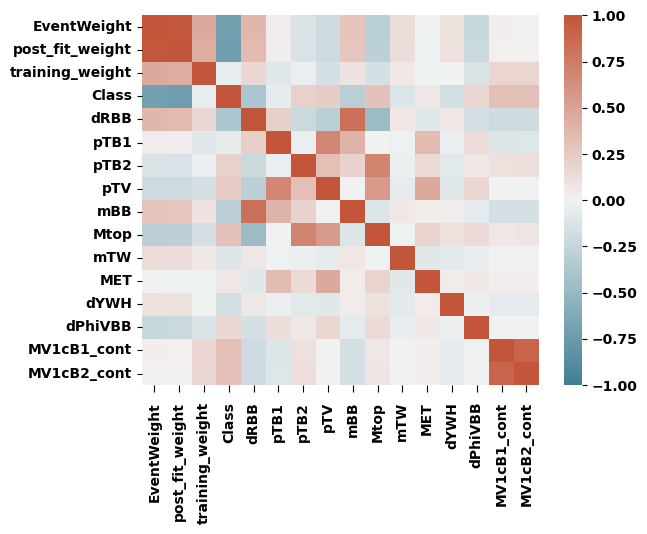

In [46]:
sns.heatmap(df_trim.corr(numeric_only=True),
            vmin=-1,vmax=1,
            cmap=sns.diverging_palette(220, 20, as_cmap=True));
plt.show()

In [47]:
print(df_trim.corr(numeric_only=True)['post_fit_weight']['EventWeight'])

0.9921342033076843


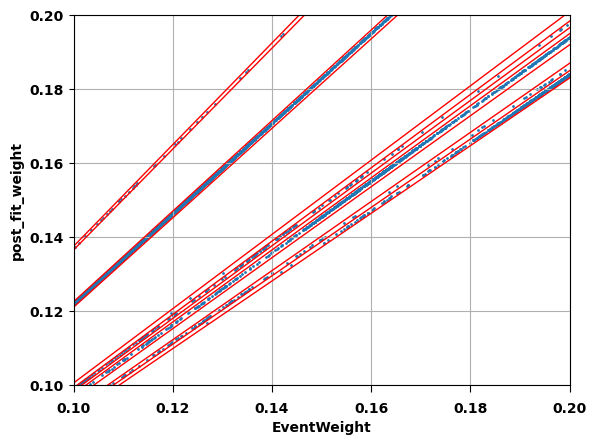

In [50]:
ax = plt.subplot()
ax.scatter(df_trim['EventWeight'], df_trim['post_fit_weight'], s=1)
ax.set_xlabel('EventWeight')
ax.set_ylabel('post_fit_weight')
ax.grid()
ax.set_xlim(0.1,0.2)
ax.set_ylim(0.1,0.2)

xspace = np.linspace(0.1,0.2)

def bounding_lines(grads):
  for grad in grads:
    plt.plot(xspace,grad*xspace,color='r',linewidth=1)

bounding_lines([0.915,0.925,0.935,0.96,0.975,0.983,0.992,1.005,1.21,1.225,1.365,1.375])

In [48]:
def filter_coeff_ratio(df, nom, denom, ranges):
    coeff_ratio = df[nom]/df[denom]
    ax = plt.subplot()
    for i in range(len(ranges)-1):
      filter = (coeff_ratio >= ranges[i]) & (coeff_ratio <= ranges[i+1])
      if len(df[filter]) != 0:
        ax.plot(df[filter][denom], df[filter][nom], '.', markersize=2, alpha=0.5, label=f"{ranges[i]} - {ranges[i+1]}")
        print(f"{ranges[i]} - {ranges[i+1]}\n", df[filter]['sample'].value_counts(),'\n')
    plt.xlabel(denom)
    plt.ylabel(nom)
    ax.set_xlim(0.06,0.1)
    ax.set_ylim(0.06,0.1)
    ax.legend()
    ax.grid()

0.915 - 0.925
 sample
ttbar    9379
Name: count, dtype: int64 

0.925 - 0.935
 sample
Wl     2875
Wcl    1406
Name: count, dtype: int64 

0.96 - 0.975
 sample
stops     2280
stopt     1610
stopWt     957
Name: count, dtype: int64 

0.983 - 0.992
 sample
WZ    1168
Zl     402
ZZ     195
WW     159
Name: count, dtype: int64 

0.992 - 1.005
 sample
qqWlvH125    65056
qqZllH125     6162
ggZllH125      836
Zcl            132
ggZvvH125        2
Name: count, dtype: int64 

1.21 - 1.225
 sample
Wbb    12561
Wbc     1037
Wcc      986
Wbl      544
Name: count, dtype: int64 

1.365 - 1.375
 sample
Zbb    2227
Zcc     106
Zbl      96
Zbc      76
Name: count, dtype: int64 



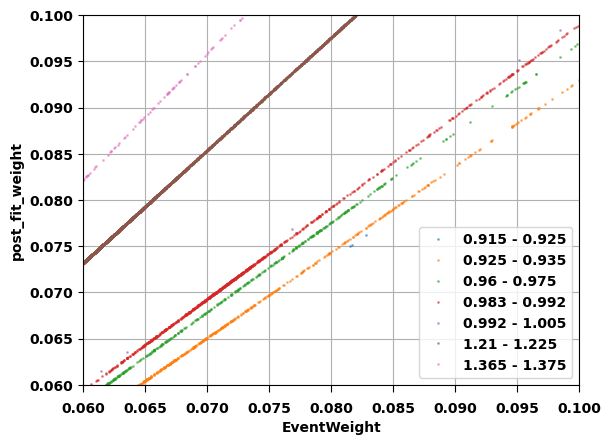

In [51]:
# filtering out different linear trends between post_fit_weight/training and EventWeight to 'reverse engineer' what contributes to the coefficients
filter_coeff_ratio(df_trim, 'post_fit_weight', 'EventWeight', [0.915,0.925,0.935,0.96,0.975,0.983,0.992,1.005,1.21,1.225,1.365,1.375])

#ax = plt.subplot()
#ax.scatter(df_trim[slope_filter_ep1]['EventWeight'], df_trim[slope_filter_ep1]['post_fit_weight'],s=2)

Index(['sample', 'category', 'EventWeight', 'post_fit_weight',
       'training_weight', 'Class', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB',
       'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont'],
      dtype='object')


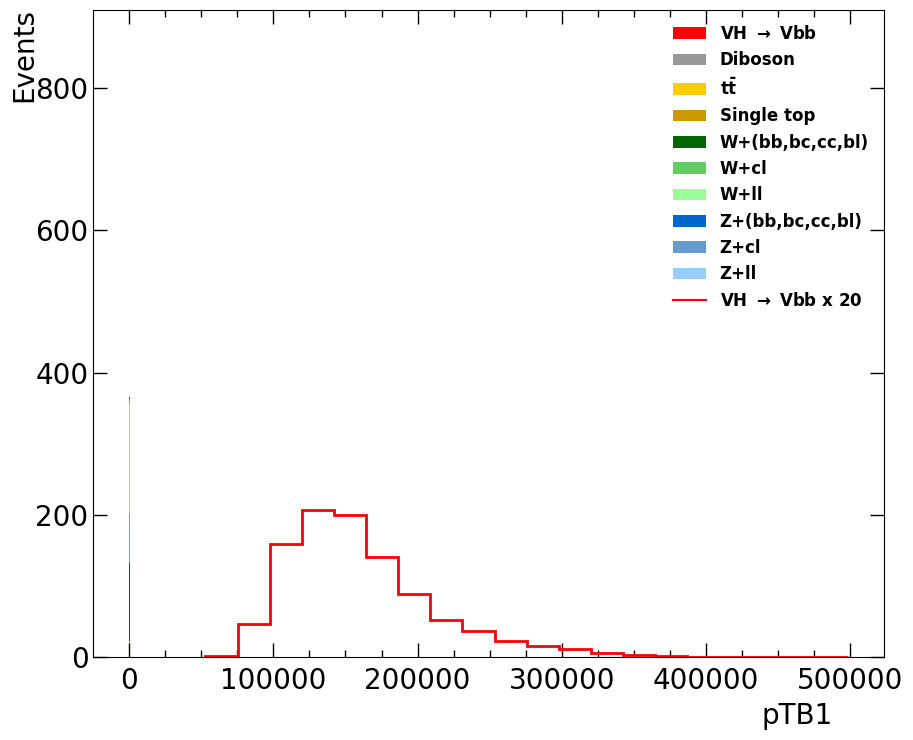

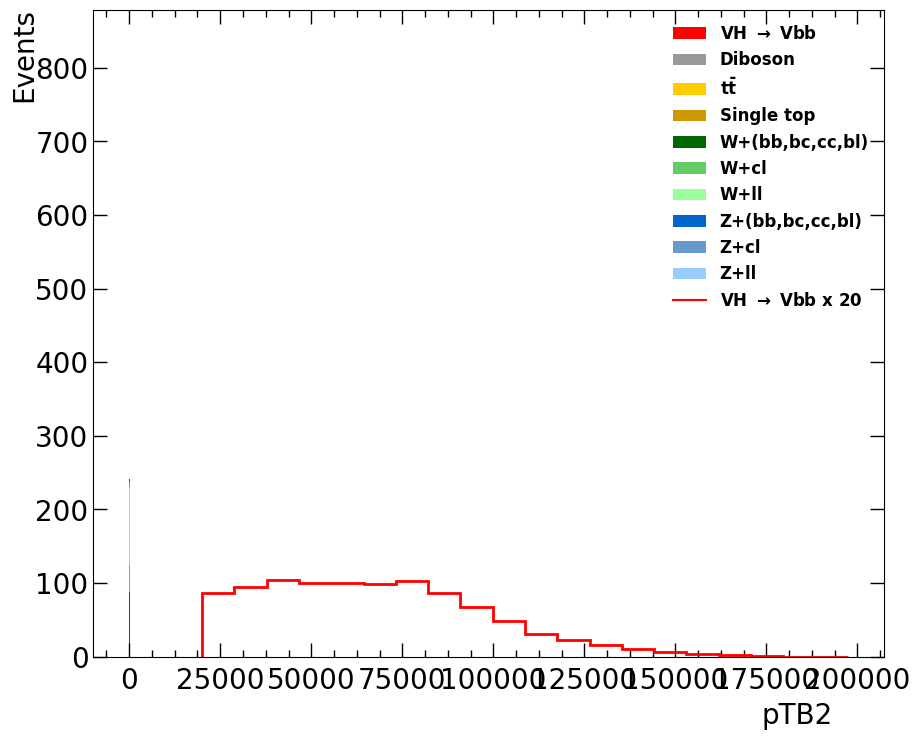

In [52]:
print(df_trim.columns)

# seem to be an issue when graphing the histograms for variables including pTB1/2
# - histograms are not scaled by the same 1/1e3 factor

#plot_variable(df_trim, 'mBB')
#plot_variable(df_trim, 'MET')
plot_variable(df_trim, 'pTB1')
plot_variable(df_trim, 'pTB2')

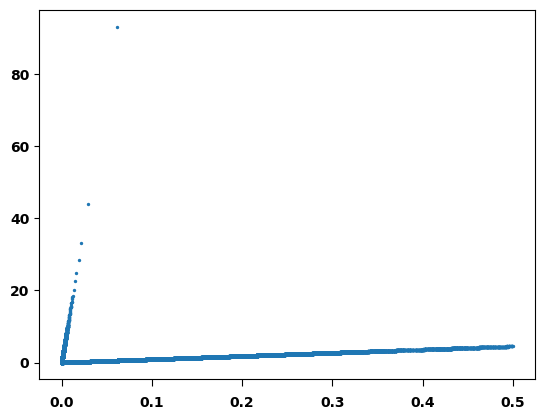

In [37]:
plt.scatter(df_trim['EventWeight'], df_trim['training_weight'], s=2)
#plt.scatter('divide by 30')

In [111]:
train_event_ratio = df_trim['training_weight']/df_trim['EventWeight']
slope_filter_te1 =  train_event_ratio > 850

df_trim[slope_filter_te1]['sample'].value_counts()


,count
sample,
qqWlvH125,65056
qqZllH125,6162
ggZllH125,836
ttbar,22
ggZvvH125,2


In [112]:
df_trim[~slope_filter_et1]['sample'].value_counts()

,count
sample,
Wbb,12561
ttbar,9357
Wl,2875
stops,2280
Zbb,2227
stopt,1610
Wcl,1406
WZ,1168
Wbc,1037
